In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
import numpy as np
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("./data/")
)

## Movie Feature Engineering

In [4]:
movie_genres = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))
movie_genres.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [5]:
movie_tags = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))
movie_tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [6]:
movie_tags["tags_nunique"] = movie_tags["tags_nunique"].astype(np.int64)

In [7]:
tags_ds = nvt.Dataset(movie_tags)

In [8]:
cat_with_genres = ["tags_unique", "movieId"] >> nvt.ops.JoinExternal(movie_genres, on=["movieId"])

In [9]:
cat_features = cat_with_genres >> nvt.ops.Categorify()

In [10]:
# cat_features = ["movieId"] >> nvt.ops.Categorify(dtype=np.int64)

In [11]:
cont_features = nvt.ColumnGroup([])
other_features = nvt.ColumnGroup(["tags_nunique"])

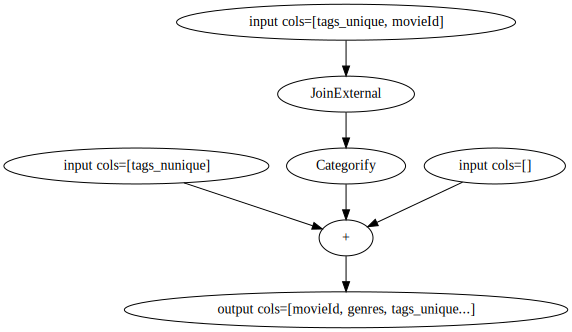

In [12]:
output = cat_features + cont_features + other_features
(output).graph

In [13]:
workflow = nvt.Workflow(output)

In [14]:
%%time
workflow.fit(tags_ds)

CPU times: user 390 ms, sys: 25.4 ms, total: 415 ms
Wall time: 426 ms


In [15]:
%time
movie_features = workflow.transform(tags_ds)

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 3.58 µs


In [16]:
movie_features.head()

,movieId,genres,tags_unique,tags_nunique
0,1,"[3, 4, 5, 6, 10]","[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ...",126
1,2,"[3, 5, 10]","[1206, 4448, 5069, 5213, 7883, 8912, 9116, 925...",44
2,3,"[6, 16]","[2196, 4356, 4448, 6484, 11460, 12274, 17647, ...",23
3,4,"[6, 9, 16]","[4448, 31525, 34749, 34981, 39134, 48169, 6086...",8
4,5,[6],"[4448, 5693, 6977, 8912, 23756, 25354, 28604, ...",20


In [17]:
movie_features_df = movie_features.to_ddf().compute()

In [18]:
type(movie_features_df)

cudf.core.dataframe.DataFrame

In [19]:
type(movie_features_df["genres"].iloc[0][0])

int

In [45]:
import datetime

timestamp = datetime.datetime.now()
movie_features_df["datetime"] = timestamp
movie_features_df["created"] = timestamp

In [46]:
movie_features_df.head()

,movieId,tags_nunique,datetime,created
0,1,126,2021-06-14 09:24:35.269240,2021-06-14 09:24:35.269240
1,2,44,2021-06-14 09:24:35.269240,2021-06-14 09:24:35.269240
2,3,23,2021-06-14 09:24:35.269240,2021-06-14 09:24:35.269240
3,4,8,2021-06-14 09:24:35.269240,2021-06-14 09:24:35.269240
4,5,20,2021-06-14 09:24:35.269240,2021-06-14 09:24:35.269240


In [47]:
movie_features_df["movieId"].dtype

dtype('int64')

In [48]:
movie_features_df.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features_slim.parquet"))

In [32]:
# def first(x):
#     return x[0]

# movie_features_df['genres'].applymap(first)
# movie_features_df['tags_unique'].applymap(first)

In [43]:
movie_features_df = movie_features_df.drop(labels=["genres", "tags_unique"], axis=1)

In [44]:
movie_features.head()

,movieId,genres,tags_unique,tags_nunique
0,1,"[3, 4, 5, 6, 10]","[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ...",126
1,2,"[3, 5, 10]","[1206, 4448, 5069, 5213, 7883, 8912, 9116, 925...",44
2,3,"[6, 16]","[2196, 4356, 4448, 6484, 11460, 12274, 17647, ...",23
3,4,"[6, 9, 16]","[4448, 31525, 34749, 34981, 39134, 48169, 6086...",8
4,5,[6],"[4448, 5693, 6977, 8912, 23756, 25354, 28604, ...",20


In [24]:
workflow.save(os.path.join(INPUT_DATA_DIR, "movie_features_workflow"))